In [1]:
# add system path
import sys,os
sys.path.append('/'.join(os.getcwd().split('/')[:-1]))

In [2]:
import nltk
import re
import numpy as np
import collections
import warnings
from sklearn.pipeline import Pipeline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from definitions import ROOT_DIR
nltk.download('punkt')

import string
from src.preprocessing.custom_transformers import PunctuationRemover, StopWordsRemover, IntoLowerCase, ShortToLong
from src.visualizers.visualiers import get_stats, get_tf_idf_scores
sns.set(style="darkgrid")

[nltk_data] Downloading package punkt to /home/ievgen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Download Jigsaw database
j_df = pd.read_csv(ROOT_DIR+'/raw_data/jigsaw_dataset.csv')
j_df.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


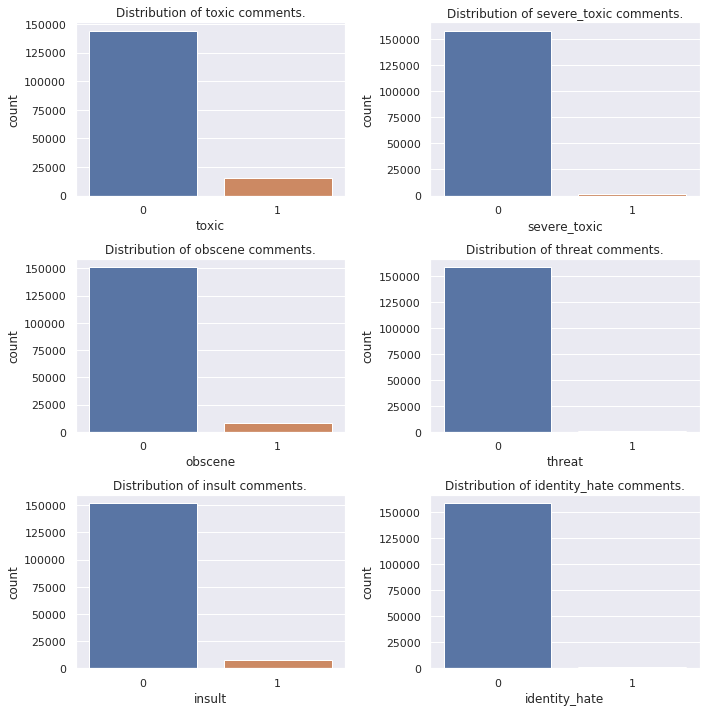

In [4]:
# Target value distribution
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
axes = axes.flatten()
number = 0
for column in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    sns.countplot(x=column, data=j_df, ax=axes[number]).set_title("Distribution of {} comments.".format(column))
    number += 1
plt.tight_layout()
plt.show()

In [5]:
# Add column with number of words
j_df['num_words'] = j_df['comment_text'].apply(
    lambda x: len([token for token in x.split(" ") if token != ""])
)
print(j_df.head(3))

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   

   severe_toxic  obscene  threat  insult  identity_hate  num_words  
0             0        0       0       0              0         42  
1             0        0       0       0              0         17  
2             0        0       0       0              0         42  


Stats for whole dataset:
Min number of words: 1
Max number of words: 1411
Mean number of words: 66.44648463693278
Median number of words: 35.0


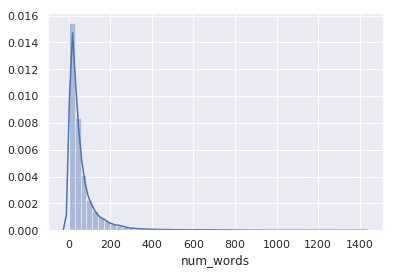

In [6]:
# Print stats for number of words
print("Stats for whole dataset:")
get_stats(j_df, 'words', 'num_words')

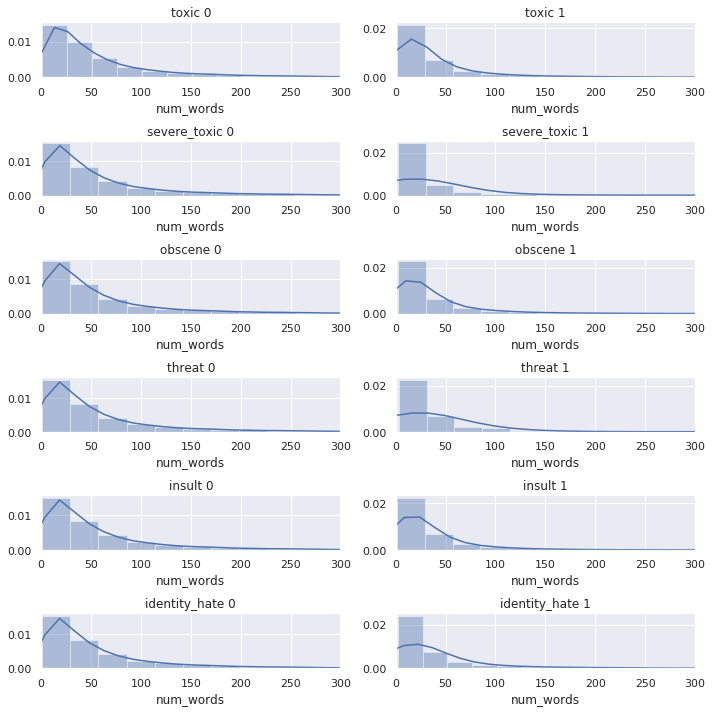

In [7]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10,10))
axes = axes.flatten()
number = 0
for column in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    for i in [0,1]:
        sns.distplot(j_df.loc[j_df[column]==i, 'num_words'], ax=axes[number]).set_title(column+" "+str(i))
        axes[number].set_xlim(0,300)
        number += 1
plt.tight_layout()
plt.show()

Each plot shows that toxic comments tend to be short.

In [8]:
# Download stop words from nltk library
nltk.download('stopwords')
eng_stop_words = nltk.corpus.stopwords.words('english') 

[nltk_data] Downloading package stopwords to /home/ievgen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Add column for text transformations
j_df['prep_text'] = j_df['comment_text'].copy()

# Create pipeline for transformation
pipeline = Pipeline(
    steps=[
        ('contracted', ShortToLong(['prep_text'])),
        ('punctuation', PunctuationRemover(['prep_text'])),
        ('lowercase', IntoLowerCase(['prep_text'])),
        ('stopwords', StopWordsRemover(['prep_text'], eng_stop_words))
    ]
)

In [10]:
# Transform the dataset using created pipeline
# j_df_transf = pipeline.fit_transform(j_df)
# j_df_transf.to_csv(ROOT_DIR + '/temp_data/jigsaw_df_transformed.csv', index=False)
j_df_transf = pd.read_csv(ROOT_DIR + '/temp_data/jigsaw_df_transformed.csv')

In [11]:
# Count words frequency for toxic comments only
df_tox_uni = get_tf_idf_scores(j_df_transf.loc[j_df_transf['toxic'] == 1, ],
                               column='prep_text', 
                               n_gram=1)
print(df_tox_uni.head(10))

       tf_idf_score      words
4378    9536.668968       bark
24879   7711.716422        pig
22722   6270.056947     nipple
13862   6203.891663    fucksex
2405    5190.097066       aids
4270    4837.203944      balls
6169    4739.724477  buttsecks
35257   4560.165214     wanker
12508   4202.036407    faggots
22928   4014.958891      noobs


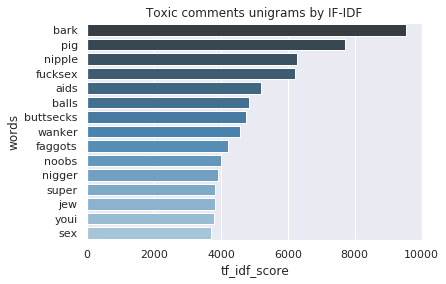

In [12]:
# plot top n words
sns.barplot(
    x="tf_idf_score",
    y="words", 
    data=df_tox_uni.head(15), 
    palette="Blues_d"
).set_title('Toxic comments unigrams by IF-IDF')

In [ ]:
# Count bigrams frequency for toxic comments only
df_tox_bi = get_tf_idf_scores(j_df_transf.loc[j_df_transf['toxic'] == 1, ],
                              'prep_text',
                              2)

Text(0.5, 1.0, 'Toxic comments bigrams by IF-IDF')

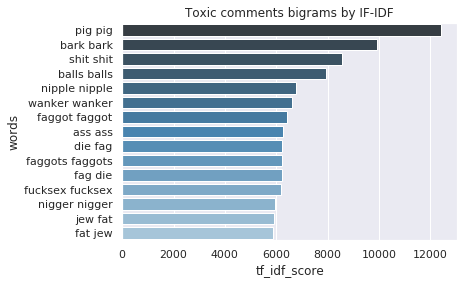

In [13]:
# plot top n words
sns.barplot(
    x="tf_idf_score",
    y="words", 
    data=df_tox_bi.head(15), 
    palette="Blues_d"
).set_title('Toxic comments bigrams by IF-IDF')

Many bigrams looks like repetition of the same word. It deserves additional investigation.

In [14]:
print(j_df_transf.shape)
j_df_transf = j_df_transf.dropna()
print(j_df_transf.shape)

(159571, 10)
(159558, 10)


In [15]:
print(j_df_transf.loc[j_df_transf['prep_text'].str.contains('faggot faggot'), 'prep_text'].values)
print("")
print(j_df_transf.loc[j_df_transf['prep_text'].str.contains('shit shit'), 'prep_text'].values)
print("")
print(j_df_transf.loc[j_df_transf['prep_text'].str.contains('ass ass'), 'prep_text'].values)

['faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot fagg

Some cases are trully repetition, but not all of them. Let's try to exclude most obvious with help of regex.

In [107]:
# function for duplicates removal
# https://stackoverflow.com/a/1875706
def duplicates_cutter(df, column, rep_text_list, n_gram):
    df_c = df.copy()
    for rep_text in rep_text_list:
        if n_gram == 'unigram':
            df_c[column] = df_c[column].str.replace(
                r"(({word})([\s,.?\w]{{1,3}}({word}\b))+)".format(word=rep_text), rep_text
            )
        elif n_gram == 'bigram':
            df_c[column] = df_c[column].str.replace(
                r"(({word})([\s,.?\w]{{1,10}}({word}\b))+)".format(word=rep_text), rep_text
            )
        else:
            raise ValueError("Parameter n_gram can be either 'unigram' or 'bigram'")
    return df_c

In [109]:
# # remove bigram duplicates
# j_df_transf_2 = duplicates_cutter(j_df_transf,
#                                   'prep_text',
#                                   df_tox_bi['words'].tolist()[:1000],
#                                   n_gram='bigram')

# # remove unigram duplicates
# j_df_transf_2 = duplicates_cutter(j_df_transf_2,
#                                   'prep_text',
#                                   df_tox_uni['words'].tolist()[:1000],
#                                   n_gram='unigram')

# # save dataframe with duplicates removed
# j_df_transf_2.to_csv(ROOT_DIR + '/temp_data/jigsaw_df_less_spam.csv', index=False)

# load dataframe with duplicates removed
j_df_transf_2 = pd.load_csv(ROOT_DIR + '/temp_data/jigsaw_df_less_spam.csv')

In [111]:
# get df idf scores
df_tox_bi_2 = get_tf_idf_scores(j_df_transf_2.loc[j_df_transf_2['toxic'] == 1, ],
                              'prep_text',
                              2)

Text(0.5, 1.0, 'Toxic comments bigrams by IF-IDF')

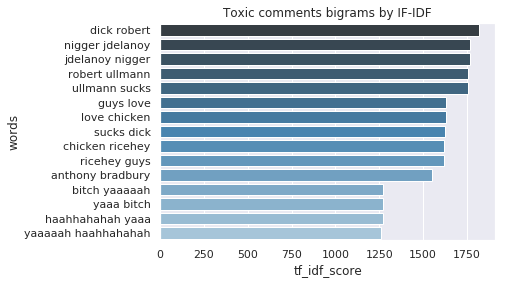

In [112]:
# plot top n words
sns.barplot(
    x="tf_idf_score",
    y="words", 
    data=df_tox_bi_2.head(15), 
    palette="Blues_d"
).set_title('Toxic comments bigrams by IF-IDF')

This set of bigrams looks musch more informative and less noisy.

In [117]:
# let's check what happend to those comments we checked previously
print(j_df_transf_2.loc[j_df_transf_2['prep_text'].str.contains('faggot faggot'), 'prep_text'].values)
print("")
print(j_df_transf_2.loc[j_df_transf_2['prep_text'].str.contains('shit shit'), 'prep_text'].values)
print("")
print(j_df_transf_2.loc[j_df_transf_2['prep_text'].str.contains('ass ass'), 'prep_text'].values)

[]

['quit changing shit shithead']

['\n\n disruptive activity \n\n please stop disruptive editing continue vandalize wikipedia paracetamol may blocked editing    🍌 email \n\nyeah add two interesting important new relevant references article indicates potential harm pregnant women paracetamol page removed guys like primary sources ridiculous frankly extreme case wrong wikipedia wife pregnant sure want know potential harm drug would think medical professional would inspired first harm idea fact wikipedia jerks focused sources narrow range whatever takes given article frustrating continued run kind thing would think academic journals taken wikipedia idea actually improved article additions others improve completely escaped much wikipedia culture days wikipedia simply forgotten idea collaboratively edited rather coterie people simply reject edits thread eye needle dozens acronym style guides guys disgusting really standing shoulders millions edits reject thing got namely lots collaborati

They became much cleaner - duplicates of bigrams where reduced to few repetitions or disappeared at all (it's ok as we still has unigram of these words).

Removal of duplicates was supposed to help with tf-idf score of unigrams. But spammed comments make this analysis useless, unless all such messages are cleared.

In [124]:
# Count words frequency for toxic comments only
df_tox_uni_2 = get_tf_idf_scores(j_df_transf_2.loc[j_df_transf_2['toxic'] == 1, ],
                               column='prep_text', 
                               n_gram=1)
print(df_tox_uni_2.head(20))

       tf_idf_score            words
18910   1831.040442               kk
33690   1754.747090          ullmann
34484   1732.961922               uu
27721   1620.567854          ricehey
5619    1552.445055         bradbury
18193   1531.495309         jdelanoy
27879   1471.305203           robert
3015    1401.864432          anthony
15170   1272.593162      haahhahahah
36580   1272.593162          yaaaaah
36578   1272.593162             yaaa
6952    1209.858294          chicken
8849    1103.576882          cuntliz
25101   1043.924078            pneis
24442   1043.924078          pennnis
24452   1043.924078  pensnsnniensnsn
18449    995.690688            jones
31438    994.367766            sucks
22609    986.392528           nigger
26263    942.789397            pussy


There are still strange words with high score: 'kk' and 'uu'. Let's investigate further.

In [126]:
# 'kk'
print(j_df_transf_2.loc[j_df_transf_2['prep_text'].str.contains(' kk '), 'prep_text'].values)

['found right next one another kk book'
 'fffffffff   uu     uu   cccccc  kk   uuuu\nfffffffff   uu     uu   cccccc\nfffff       uu     uu   cccc\nfffffffff   uu     uu   cccc\nfffffffff   uu     uu   cccc\nfffff       uu     uu   cccc\nfffff       uuuuu   cccccccccccc\nfffff       uuuuu   cccccccccccc'
 'unblock accused editin somethin didnt aint fair n ask 4 apology dont get kk fair enough wrote shit wouldent happened got apology want person accused 2 blocked aswell iam'
 'fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu c

Ok, so 'kk' and 'uu' are repeated many times in one comment. Perfect situation to spoil TF-IDF score. Let's remove them to have a clean graph.

In [132]:
j_df_transf_2['prep_text'] = j_df_transf_2['prep_text'].str.replace('fffff uu cccccc kk', 'fuck')
j_df_transf_2['prep_text'] = j_df_transf_2['prep_text'].str.replace('f uu c kk', 'fuck')
j_df_transf_2['prep_text'] = j_df_transf_2['prep_text'].str.replace('fffffffff   uu     uu   cccccc  kk', 'fuck')

In [138]:
# Count words frequency for toxic comments only
df_tox_uni_2 = get_tf_idf_scores(j_df_transf_2.loc[j_df_transf_2['toxic'] == 1, ],
                               column='prep_text', 
                               n_gram=1)
print(df_tox_uni_2.head(20))

       tf_idf_score            words
33689   1754.747090          ullmann
27720   1620.567854          ricehey
5619    1552.445055         bradbury
18193   1531.495309         jdelanoy
27878   1471.305203           robert
3015    1401.864432          anthony
36577   1272.593162             yaaa
15170   1272.593162      haahhahahah
36579   1272.593162          yaaaaah
6952    1209.858294          chicken
8849    1103.576882          cuntliz
24441   1043.924078          pennnis
25100   1043.924078            pneis
24451   1043.924078  pensnsnniensnsn
18449    995.690688            jones
31437    994.367766            sucks
22608    986.392528           nigger
26262    942.789397            pussy
13096    933.261970            fired
15117    855.945660             guys


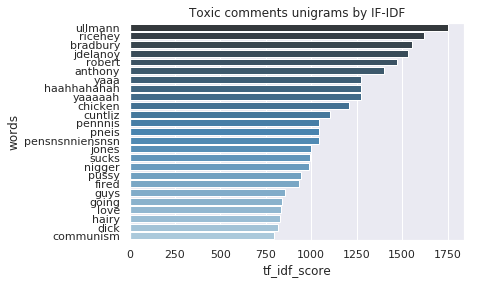

In [139]:
# plot top n words
sns.barplot(
    x="tf_idf_score",
    y="words", 
    data=df_tox_uni_2.head(25), 
    palette="Blues_d"
).set_title('Toxic comments unigrams by IF-IDF')

#%%
df_tox_bi = get_tf_idf_scores(j_df_transf_2.loc[j_df_transf_2['toxic'] == 1, ],
                              'prep_text',
                              2)

Scores still have some strage unigrams.

In [140]:
# Other cases of spam
print(j_df_transf_2.loc[j_df_transf_2['prep_text'].str.contains(' yaaaaah '), 'prep_text'].values)

['ah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haa

Despite some cases of "spam" TF-IDF scoreas have became more informative. Also it is clear that "cleaning" from duplicates should be applied to the preprocessing pipeline.

Text(0.5, 1.0, 'Toxic comments bigrams by IF-IDF')

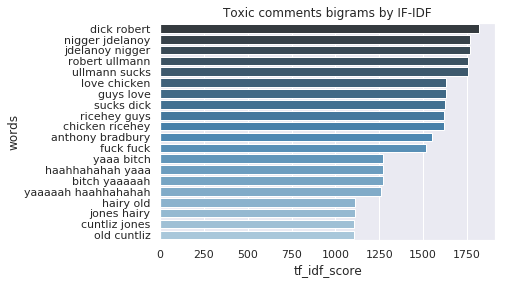

In [143]:
# get df idf scores
df_tox_bi_2 = get_tf_idf_scores(j_df_transf_2.loc[j_df_transf_2['toxic'] == 1, ],
                              'prep_text',
                              2)

# plot top n words
sns.barplot(
    x="tf_idf_score",
    y="words", 
    data=df_tox_bi_2.head(20), 
    palette="Blues_d"
).set_title('Toxic comments bigrams by IF-IDF')